# Testing code for cost function "elasticity" on the annulus

In [2]:
%pylab inline

import dionysus

Populating the interactive namespace from numpy and matplotlib


## Constructing the double annulus and combuting the cocycle

(-3.5782027754757046,
 3.5382928728762377,
 -2.160598772721965,
 2.1989485807480342)

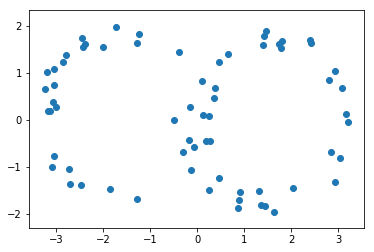

In [45]:
R = 1.5
d = .5
n = 33

# r in [0,1]
# th in [0,2pi)

from math import sin, cos, pi
from random import uniform
def rand_annulus_pt():
    r = uniform(0,1)
    th = uniform(0,2*pi)
    return (R+r*d) * cos(th), (R+r*d) * sin(th)
annulus = r_[np.array([(rand_annulus_pt()) for x in range(n)]) + [[-R,0]],
             np.array([(rand_annulus_pt()) for x in range(n)]) + [[R,0]]]
plt.scatter(*annulus.T)
plt.axis('equal')

In [46]:
prime = 19
vr = dionysus.fill_rips(annulus, 2, 4.)
cp = dionysus.cohomology_persistence(vr, prime, True)
dgms = dionysus.init_diagrams(cp, vr)

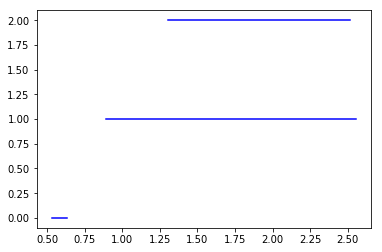

In [47]:
dionysus.plot.plot_bars(dgms[1], show=True)

# Scipy Test

In [48]:
from scipy.optimize import minimize, linprog

In [49]:
import scipy.sparse
D = {}
data = {}
indexing = {}
ix = [0]*50
thr = 1

bars = [bar for bar in dgms[1] if bar.death > thr and bar.birth < thr]
cocycles = [cp.cocycle(bar.data) for bar in bars]
vr_thr = dionysus.Filtration([s for s in vr if s.data <= thr])
coords = [dionysus.smooth(vr_thr, cocycle, prime) for cocycle in cocycles]

for s in vr:
    if s.dimension() != 1:
        continue
    D.setdefault(s.dimension(),[[],[]])
    data.setdefault(s.dimension(),[])
    indexing.setdefault(s.dimension(),{})
    indexing.setdefault(s.dimension()-1,{})
    if not s in indexing[s.dimension()]:
        indexing[s.dimension()][s] = ix[s.dimension()]
        ix[s.dimension()] += 1
    for dat, k in enumerate(s.boundary()): 
        if not k in indexing[s.dimension()-1]:
            indexing[s.dimension()-1][k] = ix[s.dimension()-1]
            ix[s.dimension()-1] += 1
        D[s.dimension()][0].append(indexing[s.dimension()][s]) #rows
        D[s.dimension()][1].append(indexing[s.dimension()-1][k]) #cols
        data[s.dimension()].append(pow(-1., dat))
import scipy as sp
CBd = [sp.sparse.csr_matrix((data[d], (D[d][0], D[d][1]))).todense() for d in range(1,max(D.keys())+1)]

In [50]:
norm(f)

268.28715958837836

In [83]:
l2_cocycle = [0 for _ in range(len(coords[0]))]
for i, coeff in enumerate(coords[0]):
    l2_cocycle[indexing[0][dionysus.Simplex([i],0)]] = coeff
l2_cocycle = np.array(l2_cocycle)
bdry = CBd[0]
n, m = CBd[0].shape
f = np.zeros((n,1))
for c2 in cocycles[0]:
    f[indexing[1][vr[c2.index]]] = mod(c2.element + (prime//2), prime) - (prime//2)
f.min(), f.max()

(-1.0, 1.0)

Derive gradient for cost function:

$$
c = \color{blue}{\|f-\delta z\|_2} + \color{green}{\lambda \|\delta z\|_2}
$$

We compute the gradient of each term separately: 

$$
\begin{align*}
\color{blue}{\left[(f-\delta z)^2\right]_j}
  &= f_j^2 - 2 f_j\sum_i \delta_{ji}z_i + \left(\sum_i \delta_{ji}z_i\right)^2 \\
\frac{\partial\|f-\delta z\|_2}{\partial z_k} 
  &= \sum_j\left[0 - 2f_j\delta_{jk}z_k + \frac{\partial}{\partial z_k}\left(\delta_{jk}^2z_k^2 + \sum_{i\neq k} 2\delta_{jk}\delta_{ji}z_kz_i\right)\right] \\
  &= \sum_j\left[-2f_j\delta_{jk}z_k + 2\delta_{jk}^2z_k + \sum_{i\neq k}2\delta_{jk}\delta_{ji}z_i\right] \\
  &= \sum_j\left[-2f_j\delta_{jk}+2\delta_{jk}\sum_i\delta_{ji}z_i\right] \\
  &= \sum_j2\delta_{jk}\left[\sum_i\delta_{ji}z_i-f_jz_k\right]
\end{align*}
$$

And

$$
\begin{align*}
\color{green}{\frac{\partial\|\left[\sum_i\delta_{ji}z_i\right]_j\|_p}{\partial z_k}}
  &= \frac{\partial}{\partial z_k}\left[\sum_j b_j^p\right]^{1/p} \\
  &= (1/p)\left[\sum_j b_j^p\right]^{1/p-1}\frac{\partial}{\partial z_k}\left[\sum_j b_j^p\right] \\
  &= \dots \\
  &= \frac{1}{\|\partial z\|_2}
  \begin{pmatrix}
  \delta_{0k} & \dots & \delta_{nk} 
  \end{pmatrix}
  \begin{pmatrix}
  b_0 \\ \vdots \\ b_n
  \end{pmatrix}
\end{align*}
$$

Combining them both into a matrix form yields

$$
\nabla cost =
\delta^T\delta z \left(2 + \frac{\lambda}{\|\delta z\|_2}\right)-2\delta^T f
\qquad
H cost = \delta^T\delta\left(2+\frac{\lambda}{\|\delta z\|_2}\right) - 2\frac{\lambda}{\|\delta z\|_2^3}\delta^T\delta z (\delta z)^T\delta - 2 (\delta^T f)
$$

In [84]:
def cost(Z,L = 1.,F = f, B = bdry):
    return np.linalg.norm(F - B*Z.reshape(Z.shape[0],1), ord=2) + L*np.linalg.norm(B*Z.reshape(Z.shape[0],1),ord=2)

def grad(Z,L = 1.,F = f, B = bdry):
    coeff_A = 2 + L/np.linalg.norm(B*Z.reshape(Z.shape[0],1),ord=2)
    dz = B*Z.reshape(Z.shape[0],1)
    return np.array(coeff_A * B.T * dz - 2 * B.T * F).flatten()

In [85]:
cost(l2_cocycle)

13.905550833833471

In [86]:
res = minimize(cost, l2_cocycle, method='BFGS', jac = grad)

Text(0.5, 1.0, 'smoothed values mod 1')

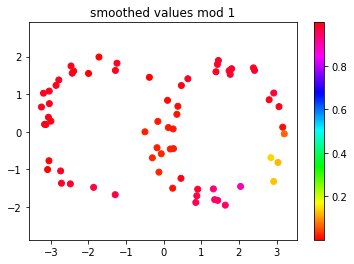

In [87]:
Zv = np.array(res.x).reshape(-1,1)
messed_ix = [indexing[0][dionysus.Simplex([n],0)] for n in range(Zv.shape[0])]
color = np.mod(Zv.T[:,messed_ix],1)
scatter(*annulus.T, c=color[0], cmap="hsv")
plt.colorbar()
plt.axis('equal')
plt.title('smoothed values mod 1')

# Linear Programming approach

By now we have defined:

* `f` the cocycle
* `bdry` the boundary matrix

and our minimizing problem is

``
min(z, |f + bdry @ z|_p)
``

We are using the linear programming translations described here: https://math.stackexchange.com/questions/706935/minimizing-l-infty-norm-using-gradient-descent

## $L_1$


$$
\min_z \|f + Bz\|_1
$$

is equivalent to

$$
\min_{z,s,t} \sum_i s_i+t_i
\quad\text{subject to}
f+Bz = s-t, (s,t) \geq 0
$$

For $L_1$, the equality constraint translates to:

$$
\begin{bmatrix}
B & \mathbb{1} & -\mathbb{1}
\end{bmatrix}
\begin{bmatrix}
z \\ s \\ t
\end{bmatrix}
= f
$$

In [88]:
### L_1

## z, s, t concatenate to form the vector zst to be optimized
## Aeq encodes the equality, which is rewritten to Bz - t + s = -f

zst = r_[zeros((bdry.shapse[1],)), ones((bdry.shape[1]*2,))] # the vector zst
Aeq = c_[bdry, ones_like(bdry), -ones_like(bdry)]
beq = f

In [89]:
zst.shape, bdry.shape, f.shape, Aeq.shape, beq.shape

((198,), (1610, 66), (1610, 1), (1610, 198), (1610, 1))

In [90]:
result = linprog(zst,
        A_eq = Aeq,
        b_eq = f,
        bounds = [(None,None)]*bdry.shape[1] + [(0,None)]*(2*bdry.shape[1])
       )

/usr/local/lib/python3.7/site-packages/scipy/optimize/_linprog_util.py:704: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  warn(redundancy_warning, OptimizeWarning)


In [91]:
result, result.x.shape

(     con: array([0., 0., 0., ..., 0., 0., 0.])
      fun: 0.0
  message: 'There is a linear combination of rows of A_eq that results in zero, suggesting a redundant constraint. However the same linear combination of b_eq is nonzero, suggesting that the constraints conflict and the problem is infeasible.'
      nit: 0
    slack: array([], dtype=float64)
   status: 2
  success: False
        x: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

Text(0.5, 1.0, 'smoothed values mod 1')

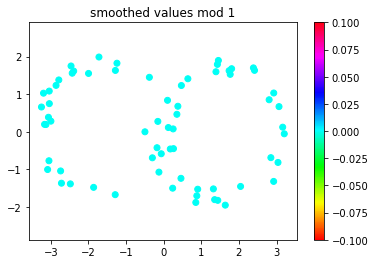

In [92]:
Zv = np.array(result.x[:bdry.shape[1]]).reshape(-1,1)
messed_ix = [indexing[0][dionysus.Simplex([n],0)] for n in range(Zv.shape[0])]
color = np.mod(Zv.T[:,messed_ix],1)
scatter(*annulus.T, c=color[0], cmap="hsv")
plt.colorbar()
plt.axis('equal')
plt.title('smoothed values mod 1')

## $L_\infty$

$$
\min_z \|f + Bz\|_\infty
$$

is equivalent to

$$
\min_{z,t} t
\quad\text{subject to}
-t\mathbb{1} \leq f+Bz\leq t\mathbb{1}
$$

The constraints translate to:

$$
\begin{bmatrix}
B & -\mathbb{1}
\end{bmatrix}
\begin{bmatrix}
z \\ t
\end{bmatrix}
\leq -f
\qquad
\begin{bmatrix}
-B & -\mathbb{1}
\end{bmatrix}
\begin{bmatrix}
z \\ t
\end{bmatrix}
\leq f
$$


which in turn can be rewritten as

$$
\begin{bmatrix}
B & -\mathbb{1} \\
-B & -\mathbb{1}
\end{bmatrix}
\begin{bmatrix}
z \\ t
\end{bmatrix}
\leq 
\begin{bmatrix}
-f \\ f
\end{bmatrix}
$$

In [93]:
### L_∞

## z, t concatenate to form the vector zt to be optimized.
## Aub and Alb encode the inequalities, with bub and blb the constants

zt = r_[zeros((bdry.shape[1],)), 1]
Aub = r_[c_[bdry, -ones((bdry.shape[0],))], c_[-bdry, -ones((bdry.shape[0],))]]
bub = r_[-f, f]

In [94]:
zt.shape, Aub.shape, bub.shape

((67,), (3220, 67), (3220, 1))

In [95]:
result = linprog(zt,
                 A_ub = Aub,
                 b_ub = bub,
                 bounds = [(None,None)]*bdry.shape[1] + [(0, None)]
       )

In [96]:
result

     con: array([], dtype=float64)
     fun: 0.0
 message: "Phase 1 of the simplex method failed to find a feasible solution. The pseudo-objective function evaluates to 6.0e+01 which exceeds the required tolerance of 1e-12 for a solution to be considered 'close enough' to zero to be a basic solution. Consider increasing the tolerance to be greater than 6.0e+01. If this tolerance is unacceptably  large the problem may be infeasible."
     nit: 1000
   slack: array([-0., -0., -0., ...,  0.,  0.,  0.])
  status: 2
 success: False
       x: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Text(0.5, 1.0, 'smoothed values mod 1')

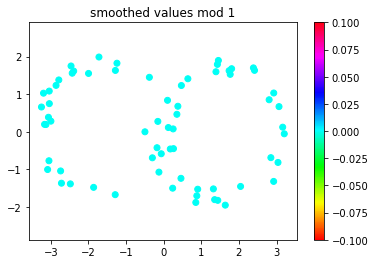

In [97]:
Zv = np.array(result.x[:bdry.shape[1]]).reshape(-1,1)
messed_ix = [indexing[0][dionysus.Simplex([n],0)] for n in range(Zv.shape[0])]
color = np.mod(Zv.T[:,messed_ix],1)
scatter(*annulus.T, c=color[0], cmap="hsv")
plt.colorbar()
plt.axis('equal')
plt.title('smoothed values mod 1')